# A simple example of  multilable learning

In [1]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
import cython
import itertools

from scipy.io import arff
from scipy.optimize import minimize
from scipy.optimize import check_grad

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
yeast_ftrain = os.path.join(data_dir, 'yeast/yeast-train.arff')
yeast_ftest  = os.path.join(data_dir, 'yeast/yeast-test.arff')

## Data loading

Load yeast dataset.

In [3]:
data_train, meta_train = arff.loadarff(yeast_ftrain)

In [4]:
data_test, meta_test = arff.loadarff(yeast_ftest)

In [5]:
type(data_train)

numpy.ndarray

In [6]:
#print(data_train[0])

Features

In [7]:
nFeatures = np.array(list(data_train[0])[:-14], dtype=np.float).shape[0]
print('#features:', nFeatures)

#features: 103


In [8]:
#np.array(list(data_train[0])[:-14], dtype=np.float)

Labels

In [9]:
nLabels = np.array(list(data_train[0])[-14:], dtype=np.int).shape[0]
print('#labels:', nLabels)

#labels: 14


In [10]:
#np.array(list(data_train[0])[-14:], dtype=np.int)

## Data analysis

In [11]:
print('#training examples:', len(data_train))

#training examples: 1500


In [12]:
print('#test examples:', len(data_test))

#test examples: 917


Histogram of #positive labels.

In [13]:
nPositives = [np.sum(np.array(list(data_train[ix])[-14:], dtype=np.int)) for ix in range(len(data_train))]

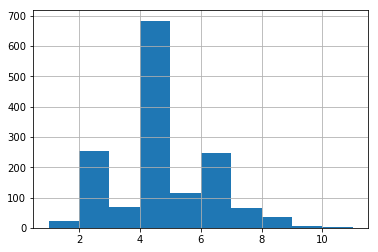

In [14]:
pd.Series(nPositives).hist(bins=10)

## Dataset creation

In [15]:
def create_dataset(label_ix, data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - label_ix: label index, number in { 0, ..., # labels }
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              y comprises the labels of the corresponding example
    """

    assert(label_ix >= 0)
    assert(label_ix < nLabels)

    N = len(data)
    d = nFeatures

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:-14]
        y[i]    = list(data[i])[-14:][label_ix]

    return X, y

In [16]:
def create_dataset_v2(data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              Y comprises the labels of the corresponding example
    """

    N = len(data)
    D = nFeatures
    L = nLabels

    X = np.zeros((N, D), dtype = np.float)
    Y = np.zeros((N, L), dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:-14]
        Y[i, :] = list(data[i])[-14:]

    return X, Y

## Evaluation

The sigmoid function.

In [17]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Loss between a ground truth and a prediction.

In [18]:
def evalPred(truth, pred, lossType = 'Hamming'):
    """
        Compute loss given ground truth and prediction
        
        Input:
            - truth:    binary array of true labels
            - pred:     real-valued array of predictions
            - lossType: can be subset 0-1, Hamming, ranking, and Precision@K where K = # positive labels.
    """

    assert(len(truth) == len(pred))
    L = len(truth)
    nPos = np.sum(truth)
    
    predBin = np.array((pred > 0), dtype=np.int)
    
    if lossType == 'Subset01':
        return 1 - int(np.all(truth == predBin))
    
    elif lossType == 'Hamming':
        return np.sum(truth != predBin) / L
    
    elif lossType == 'Ranking':
        loss = 0
        for i in range(L-1):
            for j in range(i+1, L):
                if truth[i] > truth[j]:
                    if pred[i] < pred[j]: 
                        loss += 1
                    if pred[i] == pred[j]:
                        loss += 0.5
        #return loss / (nPos * (L-nPos))
        return loss
        
    elif lossType == 'Precision@K':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:nPos])
    
    elif lossType == 'Precision@3':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:3])
    
    elif lossType == 'Precision@5':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:5])
    
    else:
        assert(False)

In [19]:
def printEvaluation(allPreds, allTruths):

    for lossType in ['Precision@K']: 
        # ['Subset01', 'Hamming', 'Ranking', 'Precision@K', 'Precision@3', 'Precision@5']:
        losses = [ ]
        for i in range(allPreds.shape[0]):
            pred  = allPreds[i, :]
            truth = allTruths[i, :]
            losses.append(evalPred(truth, pred, lossType))

            #print(allPreds[i])
            #print(pred)
            #print(truth)
            #break

        #print('%24s: %1.4f' % ('Average %s Loss' % lossType, np.mean(losses)))
        print('%s: %1.4f' % ('Average %s' % lossType, np.mean(losses)))
        #plt.hist(aucs, bins = 10);

## Binary relevance baseline

Train a logistic regression model for each label.

In [20]:
classifiers = [ LogisticRegression(class_weight = 'balanced', C = 10**0) for i in range(nLabels) ]

In [21]:
allPreds  = [ ]
allTruths = [ ]
coefMat = [ ]
labelIndices = [ ]

for label_ix in range(nLabels):
    X_train, y_train = create_dataset(label_ix, data = data_train)
    X_test, y_test   = create_dataset(label_ix, data = data_test)
    
    allTruths.append(y_test) 
    
    assert( (not np.all(y_train == 0)) or (not np.all(y_train == 1)) )

    classifiers[label_ix].fit(X_train, y_train)
    allPreds.append(classifiers[label_ix].decision_function(X_test))

    coefMat.append(classifiers[label_ix].coef_.reshape(-1))
    #labelIndices.append(label_ix)
    #print(classifiers[label_ix].coef_)
    #print(classifiers[label_ix].intercept_)

In [22]:
allPreds  = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(917, 14)
(917, 14)


In [23]:
#allPreds[0]

In [24]:
printEvaluation(allPreds, allTruths)

Average Precision@K: 0.5149


### Result analysis

Coefficient matrix `(#Genres, #Songs)`.

In [25]:
coefMat = np.array(coefMat).T

In [26]:
coefMat.shape

(103, 14)

In [27]:
#sns.heatmap(coefMat[:, :30])

## Binary relevance with exponential loss

Train a regression model with exponential loss for each label.

In [28]:
def obj_exp(w, X, y, C):
    """
        Objective with L2 regularisation and exponential loss
        
        Input:
            - w: current weight vector
            - X: feature matrix, N x D
            - y: label vector,   N x 1
            - C: regularisation constant
    """
    assert(len(y) == X.shape[0])
    assert(len(w) == X.shape[1])
    assert(C >= 0)
    
    N, D = X.shape
    
    J = 0.0  # cost
    g = np.zeros_like(w)  # gradient
    
    for n in range(N):
        x = X[n, :]
        prod = np.dot(w, x)
        
        # negative label
        if y[n] == 0:
            t1 = np.exp(prod)
            J += t1
            g = g + t1 * x
        
        # positive label
        else:
            t2 = np.exp(-prod)
            J += t2
            g = g - t2 * x
    
    J = 0.5 * C * np.dot(w, w) + J / N
    g = C * w + g / N
    
    return (J, g)

Check gradient.

In [29]:
X_train_, y_train_ = create_dataset(3, data = data_train)

In [30]:
w0 = np.random.rand(X_train_.shape[1])
C = 1
check_grad(lambda w: obj_exp(w, X_train_, y_train_, C)[0], \
           lambda w: obj_exp(w, X_train_, y_train_, C)[1], w0)

1.482649913762204e-06

In [31]:
params    = [ ]
allPreds  = [ ]
allTruths = [ ]
C = 1

for label_ix in range(nLabels):
    #sys.stdout.write('\r%d / %d' % (label_ix + 1, nLabels))
    #sys.stdout.flush()
    print('\r%d / %d ' % (label_ix + 1, nLabels))
    
    X_train, y_train = create_dataset(label_ix, data = data_train)
    X_test, y_test   = create_dataset(label_ix, data = data_test)
    
    allTruths.append(y_test) 
    
    assert( (not np.all(y_train == 0)) or (not np.all(y_train == 1)) )
        
    opt_method = 'BFGS' #'Newton-CG' 
    #opt_method = 'nelder-mead'
    options = {'disp': True}
    
    w0 = np.random.rand(X_train.shape[1])  # initial guess
    opt = minimize(obj_exp, w0, args=(X_train, y_train, C), method=opt_method, jac=True, options=options)
    
    if opt.success == True:
        w = opt.x
        params.append(w)
        #allPreds.append(sigmoid(np.dot(X_test, w)))
        allPreds.append(np.dot(X_test, w))
    else:
        sys.stderr.write('Optimisation failed, label_ix=%d\n' % label_ix)
        w = np.zeros(X_train.shape[1])
        params.append(w)
        allPreds.append(np.dot(X_test, w))

1 / 14 
Optimization terminated successfully.
         Current function value: 0.995826
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
2 / 14 
Optimization terminated successfully.
         Current function value: 0.997287
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
3 / 14 
Optimization terminated successfully.
         Current function value: 0.994601
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
4 / 14 
Optimization terminated successfully.
         Current function value: 0.992873
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
5 / 14 
Optimization terminated successfully.
         Current function value: 0.996471
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
6 / 14 
Optimization terminated successfully.
         Current function value: 0.998130
         Iterations: 5
    

In [32]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(917, 14)
(917, 14)


In [33]:
#allPreds[0]

In [34]:
printEvaluation(allPreds, allTruths)

Average Precision@K: 0.4874


## Binary relevance with bipartite ranking

Train a bipartite ranking model for each label.

In [35]:
#%load_ext Cython

In [36]:
#%%cython -a

import numpy as np
#cimport numpy as np

#cpdef obj_biranking(w, X, y):

def obj_biranking(w, X, y, C):
    """
        Objective with L2 regularisation and bipartite ranking loss
        
        Input:
            - w: current weight vector
            - X: feature matrix, N x D
            - y: label vector,   N x 1
            - C: regularisation constant
    """
    assert(len(y) == X.shape[0])
    assert(len(w) == X.shape[1])
    assert(C >= 0)

    #cdef int nPos, nNeg, i, j
    #cdef double J, term, denom
    nPos = np.sum(y)      # num of positive examples
    nNeg = len(y) - nPos  # num of negative examples
    
    ixPos = np.nonzero(y)[0].tolist()                    # indices positive examples
    ixNeg = list(set(np.arange(len(y))) - set(ixPos))    # indices negative examples
    
    J = 0.0  # cost
    g = np.zeros_like(w)  # gradient    

    scorePos = X[ixPos, :].dot(w)[:,np.newaxis] # nPos x 1
    scoreNeg = X[ixNeg, :].dot(w)[:,np.newaxis] # nNeg x 1
    scoreDif = scorePos - scoreNeg.T            # nPos x nNeg
    #J = np.mean(np.log(1 + np.exp(-scoreDif)))
    J = 0.5 * C * np.dot(w, w) + np.mean(np.log1p(np.exp(-scoreDif)))
    
    A = -1/(1 + np.exp(scoreDif))

    T1 = X[ixPos, :].T.dot(A.sum(axis = 1))
    T2 = X[ixNeg, :].T.dot(A.sum(axis = 0))
    g  = C * w + 1/(nPos * nNeg) * (T1 - T2)
    
    return (J, g)

Check gradient.

In [37]:
X_train_, y_train_ = create_dataset(6, data = data_train)

In [38]:
w0 = w = np.random.rand(X_train_.shape[1])
C = 1
check_grad(lambda w: obj_biranking(w, X_train_, y_train_, C)[0], \
           lambda w: obj_biranking(w, X_train_, y_train_, C)[1], w0)

2.8448924291952094e-06

In [39]:
#1.1331503772158218e-06 * np.sqrt(nLabels)

In [40]:
params    = [ ]
allPreds  = [ ]
allTruths = [ ]
C = 1

for label_ix in range(nLabels):
    #sys.stdout.write('\r%d / %d' % (label_ix + 1, nLabels))
    #sys.stdout.flush()
    print('\r%d / %d ' % (label_ix + 1, nLabels))
    
    X_train, y_train = create_dataset(label_ix, data = data_train)
    X_test, y_test   = create_dataset(label_ix, data = data_test)
    
    allTruths.append(y_test) 
    
    assert( (not np.all(y_train == 0)) or (not np.all(y_train == 1)) )
        
    opt_method = 'BFGS' #'Newton-CG' 
    #opt_method = 'nelder-mead'
    options = {'disp': True}
    
    w0 = np.random.rand(X_train.shape[1])  # initial guess
    opt = minimize(obj_biranking, w0, args=(X_train, y_train, C), method=opt_method, jac=True, options=options)
    
    if opt.success == True:
        w = opt.x
        params.append(w)
        allPreds.append(sigmoid(np.dot(X_test, w)))
    else:
        sys.stderr.write('Optimisation failed, label_ix=%d\n' % label_ix)
        w = np.zeros(X_train.shape[1])
        params.append(w)
        allPreds.append(np.dot(X_test, w))

1 / 14 
Optimization terminated successfully.
         Current function value: 0.687650
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
2 / 14 
Optimization terminated successfully.
         Current function value: 0.690264
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
3 / 14 
Optimization terminated successfully.
         Current function value: 0.687208
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
4 / 14 
Optimization terminated successfully.
         Current function value: 0.684365
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
5 / 14 
Optimization terminated successfully.
         Current function value: 0.687649
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
6 / 14 
Optimization terminated successfully.
         Current function value: 0.689686
         Iterations: 5
    

In [41]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(917, 14)
(917, 14)


In [42]:
#allPreds[0]

In [43]:
printEvaluation(allPreds, allTruths)

Average Precision@K: 0.4400


## Ranking loss

Multi-label learning with ranking loss.

In [44]:
#%load_ext Cython

In [45]:
#%%cython -a

import numpy as np
#cimport numpy as np

#cpdef obj_ranking(w, X, y):

def obj_ranking_loop(w, X, Y, C):
    """
        Objective with L2 regularisation and ranking loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    
    W = w.reshape(L, D)  # reshape weight matrix    
    
    #cdef int nPos, nNeg, i, j
    #cdef double J, term, denom
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for n in range(N):
        Jn = 0.0
        Gn = np.zeros_like(W)
        x = X[n, :]
        y = Y[n, :]
        nPos = np.sum(y)   # num of positive examples
        nNeg = L - nPos    # num of negative examples
        denom = nPos * nNeg
        
        ixPos = np.nonzero(y)[0].tolist()               # indices positive examples
        ixNeg = list(set(np.arange(L)) - set(ixPos))    # indices negative examples
        
        for i in ixPos:
            for j in ixNeg:
                wDiff = W[i, :] - W[j, :]
                sDiff = np.dot(wDiff, x)
                term = np.exp(sDiff)
                Jn += np.log1p(1.0 / term)
                Gn[i, :] = Gn[i, :] - x / (1 + term)        
        #for j in ixNeg:
        #    for i in ixPos:
        #        wDiff = W[i, :] - W[j, :]
        #        sDiff = np.dot(wDiff, x)
        #        term = np.exp(sDiff)
                Gn[j, :] = Gn[j, :] + x / (1 + term)
                
        J += Jn / denom
        G = G + Gn / denom
        
    J = 0.5 * C * np.dot(w, w) + J / N
    G = C * W + G / N
    
    return (J, G.ravel())

In [46]:
#np.tile([1,2,3], (3,1)) * np.array([0.1, 0.2, 0.3])[:, None]

In [47]:
def obj_ranking(w, X, Y, C):
    """
        Objective with L2 regularisation and ranking loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    
    W = w.reshape(L, D)  # reshape weight matrix    
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for n in range(N):
        Jn = 0.0
        Gn = np.zeros_like(W)
        x = X[n, :]
        y = Y[n, :]
        nPos = np.sum(y)   # num of positive examples
        nNeg = L - nPos    # num of negative examples
        denom = nPos * nNeg
        
        ixPos = np.nonzero(y)[0].tolist()               # indices positive examples
        ixNeg = list(set(np.arange(L)) - set(ixPos))    # indices negative examples
        
        ixmat = np.array(list(itertools.product(ixPos, ixNeg)))  # shape: ixPos*ixNeg by 2
        dW = W[ixmat[:, 0], :] - W[ixmat[:, 1], :]
        sVec = np.dot(dW, x)
        Jn = np.sum(np.log1p(np.exp(-sVec)))
        
        coeffVec = np.divide(1, 1 + np.exp(sVec))
        coeffPos = pd.DataFrame(coeffVec)
        coeffPos['gid'] = ixmat[:, 0]
        coeffPos = coeffPos.groupby('gid', sort=False).sum()
        coeffNeg = pd.DataFrame(coeffVec)
        coeffNeg['gid'] = ixmat[:, 1]
        coeffNeg = coeffNeg.groupby('gid', sort=False).sum()
        
        #print(coeffPos)
        #print(coeffNeg)
        
        coeffs = np.ones(L)
        coeffs[ixPos] = -coeffPos.loc[ixPos].values.squeeze()
        coeffs[ixNeg] = coeffNeg.loc[ixNeg].values.squeeze()
        
        #print(coeffs)
        Gn = np.tile(x, (L, 1)) * coeffs[:, None]
                        
        J += Jn / denom
        G = G + Gn / denom
        
    J = 0.5 * C * np.dot(w, w) + J / N
    G = C * W + G / N
    
    return (J, G.ravel())

In [48]:
X_train, Y_train = create_dataset_v2(data = data_train)
X_test,  Y_test  = create_dataset_v2(data = data_test)

Check gradient

In [49]:
#%%script false
C = 1
w0 = np.random.rand(nFeatures * nLabels)
check_grad(lambda w: obj_ranking(w, X_train[:10], Y_train[:10], C)[0], \
           lambda w: obj_ranking(w, X_train[:10], Y_train[:10], C)[1], w0)

4.8432207145699553e-05

In [50]:
allPreds  = None
allTruths = Y_test

opt_method = 'BFGS' #'Newton-CG' 
#opt_method = 'nelder-mead'
options = {'disp': True}

C = 1
w = np.random.rand(nFeatures * nLabels)  # initial guess
opt = minimize(obj_ranking, w, args=(X_train, Y_train, C), method=opt_method, jac=True, options=options)

if opt.success == True:
    w = opt.x
    #allPreds = sigmoid(np.dot(X_test, w.reshape(nLabels, nFeatures).T))
    allPreds = np.dot(X_test, w.reshape(nLabels, nFeatures).T)
else:
    sys.stderr.write('Optimisation failed')

Optimization terminated successfully.
         Current function value: 0.692868
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


In [51]:
#allPreds = np.array(allPreds).T
#allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(917, 14)
(917, 14)


In [63]:
#allPreds[0]

In [53]:
printEvaluation(allPreds, allTruths)

Average Precision@K: 0.4893


## p-norm push loss

Multi-label learning with p-norm push loss.

In [54]:
def obj_pnorm_push(w, X, Y, p, C):
    """
        Objective with L2 regularisation and p-norm push loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - p: constant for p-norm push loss
            - C: regularisation constant
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    assert(p >= 1)
    assert(C >= 0)
    
    W = w.reshape(L, D)  # reshape weight matrix
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for n in range(N):
        Gn = np.zeros_like(W)
        x = X[n, :]
        y = Y[n, :]
        nPos = np.sum(y)   # num of positive examples
        nNeg = L - nPos    # num of negative examples
        
        ixPos = np.nonzero(y)[0].tolist()               # indices positive examples
        ixNeg = list(set(np.arange(L)) - set(ixPos))    # indices negative examples
        
        scalingPos = np.exp(   -np.dot(W[ixPos, :], x)) / nPos
        scalingNeg = np.exp(p * np.dot(W[ixNeg, :], x)) / nNeg
        
        Gn[ixPos, :] = np.tile(-x, (nPos,1)) * scalingPos[:, None]  # scaling each row of a matrix
        Gn[ixNeg, :] = np.tile( x, (nNeg,1)) * scalingNeg[:, None]  #         with a different scalar
        
        J += np.sum(scalingPos) + np.sum(scalingNeg) / p
        G = G + Gn
        
    J = 0.5 * C * np.dot(w, w) + J / N
    G = C * W + G / N
    
    return (J, G.ravel())

In [55]:
def obj_pnorm_push_loop(w, X, Y, p, C):
    """
        Objective with L2 regularisation and p-norm push loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - p: constant for p-norm push loss
            - C: regularisation constant
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    assert(p >= 1)
    assert(C >= 0)
    
    W = w.reshape(L, D)  # reshape weight matrix
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for n in range(N):
        Gn = np.zeros_like(W)
        x = X[n, :]
        y = Y[n, :]
        nPos = np.sum(y)   # num of positive examples
        nNeg = L - nPos    # num of negative examples
        
        for k in range(L):
            wk = W[k, :]
            term = np.dot(wk, x)
            if y[k] == 1:
                term2 = np.exp(-term) / nPos
                J += term2
                Gn[k, :] = -x * term2
            else:
                term2 = np.exp(p * term) / nNeg
                J += term2 / p
                Gn[k, :] = x * term2
        G = G + Gn
        
    J = 0.5 * C * np.dot(w, w) + J / N
    G = C * W + G / N
    
    return (J, G.ravel())

In [56]:
X_train, Y_train = create_dataset_v2(data = data_train)
X_test,  Y_test  = create_dataset_v2(data = data_test)

Check gradient

In [57]:
p = 1
C = 1
w0 = np.random.rand(nFeatures * nLabels)
check_grad(lambda w: obj_pnorm_push(w, X_train, Y_train, p, C)[0], \
           lambda w: obj_pnorm_push(w, X_train, Y_train, p, C)[1], w0)

3.7422676413714687e-05

In [58]:
allPreds  = None
allTruths = Y_test
p = 1  # [1, 10]
C = 1  # [0, 1]

opt_method = 'BFGS' #'Newton-CG' 
#opt_method = 'nelder-mead'
options = {'disp': True}

w0 = np.random.rand(nFeatures * nLabels)  # initial guess
opt = minimize(obj_pnorm_push, w0, args=(X_train, Y_train, p, C), method=opt_method, jac=True, options=options)

if opt.success == True:
    w = opt.x
    allPreds = np.dot(X_test, w.reshape(nLabels, nFeatures).T)
else:
    sys.stderr.write('Optimisation failed')

Optimization terminated successfully.
         Current function value: 1.998892
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


In [59]:
#allPreds = np.array(allPreds).T
#allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(917, 14)
(917, 14)


In [60]:
#allPreds[0]

In [61]:
printEvaluation(allPreds, allTruths)

Average Precision@K: 0.4896


### Results for different hyper-parameter configurations

In [62]:
allTruths = Y_test
allTruths_train = Y_train
opt_method = 'BFGS' #'Newton-CG' 

for p in [1, 10]:
    for C in [0, 1]:
        print('-------------------------------------')
        print('p in loss: {}, C for regularisation: {}'.format(p, C))
        allPreds  = None

        w0 = np.random.rand(nFeatures * nLabels)  # initial guess
        opt = minimize(obj_pnorm_push, w0, args=(X_train, Y_train, p, C), method=opt_method, jac=True)

        if opt.success == True:
            w = opt.x
            allPreds = np.dot(X_test, w.reshape(nLabels, nFeatures).T)
            allPreds_train = np.dot(X_train, w.reshape(nLabels, nFeatures).T)
        else:
            sys.stderr.write('Optimisation failed')
        print('Evaluation on training set:')
        printEvaluation(allPreds_train, allTruths_train)
        print()
        print('Evaluation on test set:')
        printEvaluation(allPreds, allTruths)
        print()

-------------------------------------
p in loss: 1, C for regularisation: 0
Evaluation on training set:
Average Precision@K: 0.5641

Evaluation on test set:
Average Precision@K: 0.4720

-------------------------------------
p in loss: 1, C for regularisation: 1
Evaluation on training set:
Average Precision@K: 0.5161

Evaluation on test set:
Average Precision@K: 0.4896

-------------------------------------
p in loss: 10, C for regularisation: 0
Evaluation on training set:
Average Precision@K: 0.5976

Evaluation on test set:
Average Precision@K: 0.4940

-------------------------------------
p in loss: 10, C for regularisation: 1
Evaluation on training set:
Average Precision@K: 0.5189

Evaluation on test set:
Average Precision@K: 0.4906

